## Nonlinear Dimensionality Reduction
G. Richards (2016), based on materials from Ivezic, Connolly, Miller, Leighly, and VanderPlas.

Today we will talk about the concepts of 
* manifold learning
* nonlinear dimensionality reduction

Specifically using the following algorithms
* local linear embedding (LLE)
* isometric mapping (IsoMap)
* t-distributed Stochastic Neighbor Embedding (t-SNE)

Let's start by my echoing the brief note of caution given in Adam Miller's notebook: "astronomers will often try to derive physical insight from PCA eigenspectra or eigentimeseries, but this is not advisable as there is no physical reason for the data to be linearly and orthogonally separable".  Moreover, physical components are (generally) positive definite.  So, PCA is great for dimensional reduction, but for doing physics there are generally better choices.

While NMF "solves" the issue of negative components, it is still a linear process.  For data with non-linear correlations, an entire field, known as [Manifold Learning](http://scikit-learn.org/stable/modules/manifold.html) and [nonlinear dimensionality reduction]( https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction), has been developed, with several algorithms available via the [`sklearn.manifold`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.manifold) module. 

For example, if your data set looks like this:
![Ivezic, Figure 7.8a](images/IvezicFigure7p8a.png)

Then PCA is going to give you something like this.  

![Ivezic, Figure 7.8b](images/IvezicFigure7p8b.png)

Clearly not very helpful!

What you really want is something more like the results below.  For more examples see
[Vanderplas & Connolly 2009](http://iopscience.iop.org/article/10.1088/0004-6256/138/5/1365/meta;jsessionid=48A569862A424ECCAEECE2A900D9837B.c3.iopscience.cld.iop.org)

![Ivezic, Figure 7.8cd](images/IvezicFigure7p8cd.png)

## Local Linear Embedding

[Local Linear Embedding](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html#sklearn.manifold.LocallyLinearEmbedding) attempts to embed high-$D$ data in a lower-$D$ space.  Crucially it also seeks to preserve the geometry of the local "neighborhoods" around each point.  In the case of the "S" curve, it seeks to unroll the data.  The steps are

Step 1: define local geometry
- local neighborhoods determined from $k$ nearest neighbors.
- for each point calculate weights that reconstruct a point from its $k$ nearest
neighbors via
$$
\begin{equation}
  \mathcal{E}_1(W) = \left|X - WX\right|^2,
\end{equation}
$$
where $X$ is an $N\times K$ matrix and $W$ is an $N\times N$ matrix that minimizes the reconstruction error.

Essentially this is finding the hyperplane that describes the local surface at each point within the data set. So, imagine that you have a bunch of square tiles and you are trying to tile the surface with them.


Step 2: embed within a lower dimensional space
- set all $W_{ij}=0$ except when point $j$ is one of the $k$ nearest neighbors of point $i$.  
- $W$ becomes very sparse for $k \ll N$ (only $Nk$ entries in $W$ are non-zero). 
- minimize
>$\begin{equation}
  \mathcal{E}_2(Y) = \left|Y - W Y\right|^2,
\end{equation}
$

with $W$ fixed to find an $N$ by $d$ matrix ($d$ is the new dimensionality).

Step 1 requires a nearest-neighbor search.

Step 2 requires an
eigenvalue decomposition of the matrix $C_W \equiv (I-W)^T(I-W)$.


LLE has been applied to data as diverse as galaxy spectra, stellar spectra, and photometric light curves.   It was introduced by [Roweis & Saul (2000)](https://www.ncbi.nlm.nih.gov/pubmed/11125150).

Skikit-Learn's call to LLE is as follows, with a more detailed example already being given above.

In [1]:
import numpy as np
from sklearn.manifold import LocallyLinearEmbedding
X = np.random.normal(size=(1000,2)) # 1000 points in 2D
R = np.random.random((2,10)) # projection matrix
X = np.dot(X,R) # now a 2D linear manifold in 10D space
k = 5 # Number of neighbors to use in fit
n = 2 # Number of dimensions to fit
lle = LocallyLinearEmbedding(k,n)
lle.fit(X)
proj = lle.transform(X) # 100x2 projection of the data

See what LLE does for the digits data, using the 7 nearest neighbors and 2 components.

[[  0.   0.   5.  13.   9.   1.   0.   0.]
 [  0.   0.  13.  15.  10.  15.   5.   0.]
 [  0.   3.  15.   2.   0.  11.   8.   0.]
 [  0.   4.  12.   0.   0.   8.   8.   0.]
 [  0.   5.   8.   0.   0.   9.   8.   0.]
 [  0.   4.  11.   0.   1.  12.   7.   0.]
 [  0.   2.  14.   5.  10.  12.   0.   0.]
 [  0.   0.   6.  13.  10.   0.   0.   0.]]


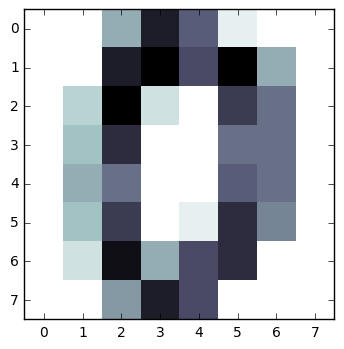

In [2]:
# Execute this cell to load the digits sample
%matplotlib inline
import numpy as np
from sklearn.datasets import load_digits
from matplotlib import pyplot as plt
digits = load_digits()
grid_data = np.reshape(digits.data[0], (8,8)) #reshape to 8x8
plt.imshow(grid_data, interpolation = "nearest", cmap = "bone_r")
print grid_data
X = digits.data
y = digits.target

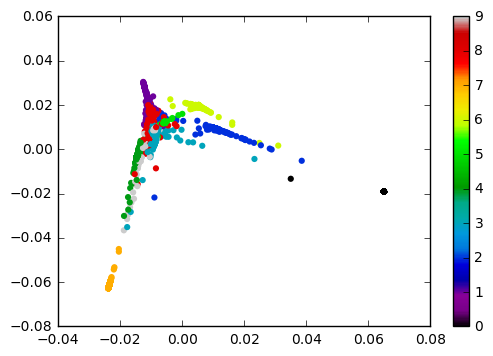

In [16]:
#LLE
from sklearn.manifold import LocallyLinearEmbedding
# Complete
k = 7 # Number of neighbors to use in fit
n = 2 # Number of dimensions to fit
lle = LocallyLinearEmbedding(n_neighbors=k, n_components=n)
lle.fit(X)
proj = lle.transform(X) 

plt.scatter(proj[:,0],proj[:,1], c=y, cmap='nipy_spectral', edgecolor='None')
plt.colorbar()


## Isometric Mapping

is based on multi-dimensional scaling (MDS) framework.  It was introduced in the same volume of science as the article above.  See [Tenenbaum, de Silva, & Langford (2000)](https://www.ncbi.nlm.nih.gov/pubmed/?term=A+Global+Geometric+Framework+for+Nonlinear+Dimensionality+Reduction).
Geodestic curves are used to recover non-linear structure.

In Scikit-Learn [IsoMap](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html) is implemented as follows:

In [17]:
# Execute this cell
import numpy as np
from sklearn.manifold import Isomap
XX = np.random.normal(size=(1000,2)) # 1000 points in 2D
R = np.random.random((2,10)) # projection matrix
XX = np.dot(XX,R) # X is a 2D manifold in 10D space
k = 5 # number of neighbors
n = 2 # number of dimensions
iso = Isomap(k,n)
iso.fit(XX)
proj = iso.transform(XX) # 1000x2 projection of the data

Try 7 neighbors and 2 dimensions on the digits data.

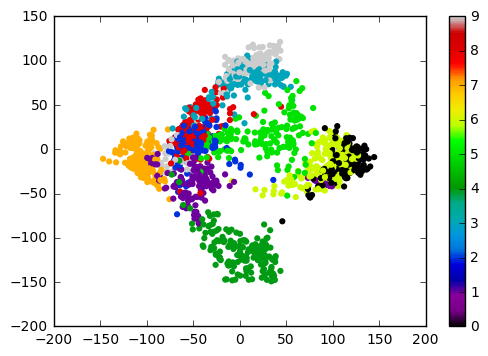

In [25]:
# IsoMap
from sklearn.manifold import Isomap
# Complete
k = 7 # Number of neighbors to use in fit
n = 2 # Number of dimensions to fit
iso = Isomap(k, n)
iso.fit(X)
proj = iso.transform(X) 

plt.scatter(proj[:,0],proj[:,1], c=y, cmap='nipy_spectral', edgecolor='None')
plt.colorbar()


## t-SNE

[t-distributed Stochastic Neighbor Embedding (t-SNE)](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) is not discussed in the book, Scikit-Learn does have a [t-SNE implementation](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) and it is well worth mentioning this manifold learning algorithm too.  SNE itself was developed by [Hinton & Roweis](http://www.cs.toronto.edu/~fritz/absps/sne.pdf) with the "$t$" part being added by [van der Maaten & Hinton](http://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf).  It works like the other manifold learning algorithms.  Try it on the digits data.

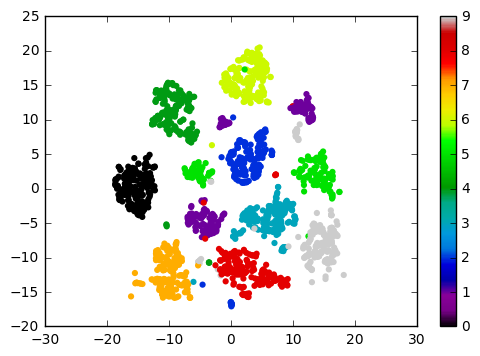

In [26]:
# t-SNE
from sklearn.manifold import TSNE
# Complete
n = 2 # Number of dimensions to fit
tnse = TSNE(n_components=n)
proj = tnse.fit_transform(X)
#proj = tnse.transform(X) 

plt.scatter(proj[:,0],proj[:,1], c=y, cmap='nipy_spectral', edgecolor='None')
plt.colorbar()
X_reduced = proj


You'll know if you have done it right if you understand Adam Miller's comment "Holy freakin' smokes.  That is magic.  (It's possible we just solved science)."

Personally, I think that some exclamation points may be needed in there!

What's even more illuminating is to make the plot using the actual digits to plot the points.  Then you can see why certain digits are alike or split into multiple regions.  Can you explain the patterns you see here?

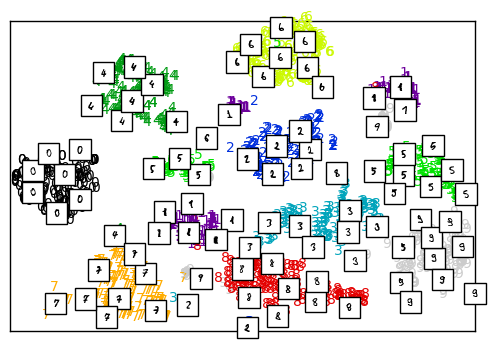

In [27]:
# Execute this cell
from matplotlib import offsetbox

#----------------------------------------------------------------------
# Scale and visualize the embedding vectors
def plot_embedding(X):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
      #plt.text(X[i, 0], X[i, 1], str(digits.target[i]), color=plt.cm.Set1(y[i] / 10.), fontdict={'weight': 'bold', 'size': 9})
      plt.text(X[i, 0], X[i, 1], str(digits.target[i]), color=plt.cm.nipy_spectral(y[i]/9.))


    shown_images = np.array([[1., 1.]])  # just something big
    for i in range(digits.data.shape[0]):
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        if np.min(dist) < 4e-3:
            # don't show points that are too close
            continue
        shown_images = np.r_[shown_images, [X[i]]]
        imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r), X[i])
        ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    
plot_embedding(X_reduced)
plt.show()

With the remainder of time in class today, play with the arguments of the algorithms that we have discussed this week and/or try running them on a different data set.  For example the iris data set or one of the other samples of data that are included with Scikit-Learn.  Or maybe have a look through some of these public data repositories:

- [https://github.com/caesar0301/awesome-public-datasets?utm_content=buffer4245d&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer](https://github.com/caesar0301/awesome-public-datasets?utm_content=buffer4245d&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer)
- [http://www.datasciencecentral.com/m/blogpost?id=6448529%3ABlogPost%3A318739](http://www.datasciencecentral.com/m/blogpost?id=6448529%3ABlogPost%3A318739)
- [http://www.kdnuggets.com/2015/04/awesome-public-datasets-github.html](http://www.kdnuggets.com/2015/04/awesome-public-datasets-github.html)